# Inferential Analysis of Developer Compensation Across Countries

This project explores the question:  
**Are young software developers (age 18–24) in the US and Germany paid equally, or is there a significant salary gap?**

We use the Stack Overflow 2024 Developer Survey, focusing on rigorous data cleaning, transformation, and statistical analysis to ensure meaningful results.

*Why this matters:*  
Salary equity is important for policy, for individuals planning careers, and for understanding the global tech labor market. Our analysis combines exploratory data analysis, hypothesis testing, and regression modeling.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from scipy.stats import t
from scipy.stats import ttest_ind

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('survey_results_public.csv')
df.shape

(65437, 114)

## Data Preparation: Focusing the Analysis

The survey contains tens of thousands of responses. To make a fair, apples-to-apples comparison, we:
- **Filter** for developers in the US and Germany
- **Limit** to respondents aged 18–24
- **Remove** salaries below country-specific minimum wage standards (to focus on full-time, professional roles)
- **Drop** incomplete records (e.g., missing work experience)


In [3]:
mask = (
    (df['Country'].isin(['Germany', 'United States of America'])) &
    (df['Age'] == '18-24 years old') &
    (df['ConvertedCompYearly'].notnull())
)
df_young = df[mask].copy()

In [4]:
len(df_young)

714

In [5]:
df_young['Country'].value_counts()

United States of America    424
Germany                     290
Name: Country, dtype: int64

In [6]:
min_wage_germany = 30401 #converted to dollar
min_wage_us = 35568
df_young_filtered = df_young[
    ((df_young['Country'] == 'Germany') & (df_young['ConvertedCompYearly'] >= min_wage_germany)) |
    ((df_young['Country'] == 'United States of America') & (df_young['ConvertedCompYearly'] >= min_wage_us))
]

In [7]:
df_young_filtered['Country'].value_counts()

United States of America    384
Germany                     156
Name: Country, dtype: int64

In [8]:
de = df_young_filtered[df_young_filtered['Country'] == 'Germany']
us = df_young_filtered[df_young_filtered['Country'] == 'United States of America']

In [9]:
print('Germany sample Size :',len(de),' ' 
      'Us sample size:',len(us))


Germany sample Size : 156  Us sample size: 384


In [10]:
de.describe()

,ResponseId,CompTotal,WorkExp,JobSatPoints_1,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,ConvertedCompYearly,JobSat
count,156.000000,1.560000e+02,108.000000,110.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,1.560000e+02,106.000000
mean,23157.666667,6.720881e+04,3.981481,15.545455,4.558559,7.117117,26.522523,23.846847,20.450450,16.801802,14.162162,9.891892,7.210142e+04,6.764151
std,11494.531602,1.151919e+05,2.340147,25.356409,12.743401,16.334425,30.201098,27.094850,27.834818,25.982099,25.048513,22.513572,1.236448e+05,2.063524
min,676.000000,2.880000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.093300e+04,0.000000
25%,13582.750000,4.200000e+04,2.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.511100e+04,6.000000
50%,23949.500000,5.000000e+04,4.000000,5.000000,0.000000,0.000000,20.000000,20.000000,10.000000,10.000000,5.000000,0.000000,5.370300e+04,7.000000
75%,32544.750000,6.000000e+04,5.000000,20.000000,0.000000,5.000000,30.000000,30.000000,24.000000,20.000000,15.000000,9.000000,6.444400e+04,8.000000
max,40819.000000,1.200000e+06,18.000000,100.000000,79.000000,96.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.288874e+06,10.000000


In [11]:
us.describe()

,ResponseId,CompTotal,WorkExp,JobSatPoints_1,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,ConvertedCompYearly,JobSat
count,384.000000,384.000000,241.000000,245.000000,246.000000,246.000000,246.00000,245.000000,246.000000,246.000000,246.000000,246.000000,384.000000,239.000000
mean,22256.351562,100865.348958,2.846473,11.061224,5.219512,4.451220,17.95935,22.559184,14.776423,12.898374,5.703252,4.634146,100865.348958,6.849372
std,11916.381592,50034.211790,1.781057,16.696186,14.406369,12.605621,20.20200,23.102976,17.694309,17.702122,14.050541,13.106327,50034.211790,2.066721
min,670.000000,36000.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,36000.000000,0.000000
25%,11818.000000,69000.000000,2.000000,0.000000,0.000000,0.000000,0.00000,5.000000,0.000000,0.000000,0.000000,0.000000,69000.000000,6.000000
50%,22710.500000,90000.000000,2.000000,5.000000,0.000000,0.000000,15.00000,20.000000,10.000000,6.000000,0.000000,0.000000,90000.000000,7.000000
75%,33282.250000,120000.000000,3.000000,15.000000,0.000000,5.000000,25.00000,30.000000,20.000000,20.000000,5.000000,5.000000,120000.000000,8.000000
max,41083.000000,500000.000000,12.000000,100.000000,100.000000,90.000000,100.00000,100.000000,90.000000,100.000000,100.000000,100.000000,500000.000000,10.000000


In [12]:
us_clean = us.dropna(subset=['WorkExp'])
de_clean = de.dropna(subset=['WorkExp'])

In [13]:
print('Germany-Clean sample Size :',len(de_clean),' ' 
      'Us-Clean sample size:',len(us_clean))

Germany-Clean sample Size : 108  Us-Clean sample size: 241


## Exploratory Data Analysis (EDA)

Before any modeling, we explore the salary distributions for each country:
- Visualize with histograms and boxplots
- Compute skewness and summary statistics

*What we found:*  
Both the US and German samples showed substantial right skew and extreme outliers This discovery motivated further data cleaning.


<Axes: xlabel='ConvertedCompYearly', ylabel='Count'>

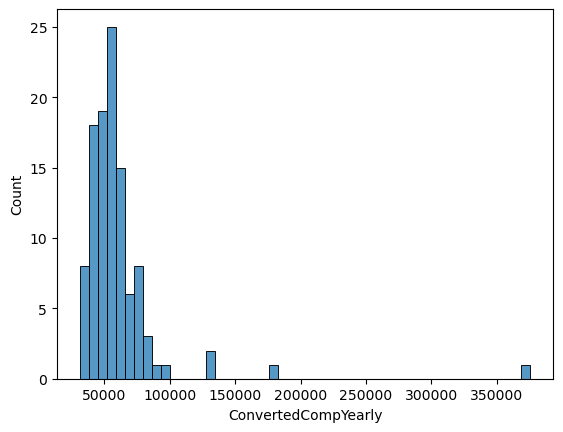

In [14]:
sns.histplot(de_clean.ConvertedCompYearly, bins= 50)

<Axes: >

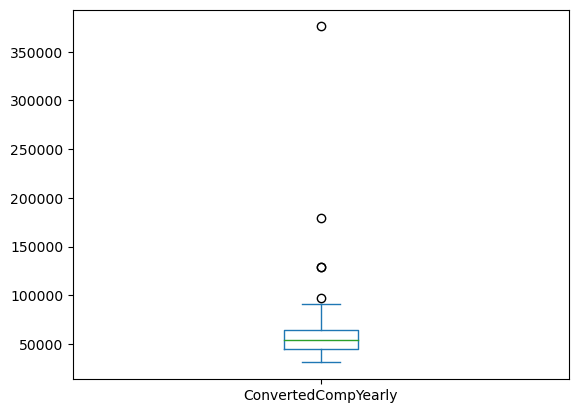

In [15]:
de_clean.ConvertedCompYearly.plot(kind= 'box')

In [16]:
de_clean.ConvertedCompYearly.skew()

6.452788185346978

<Axes: xlabel='ConvertedCompYearly', ylabel='Count'>

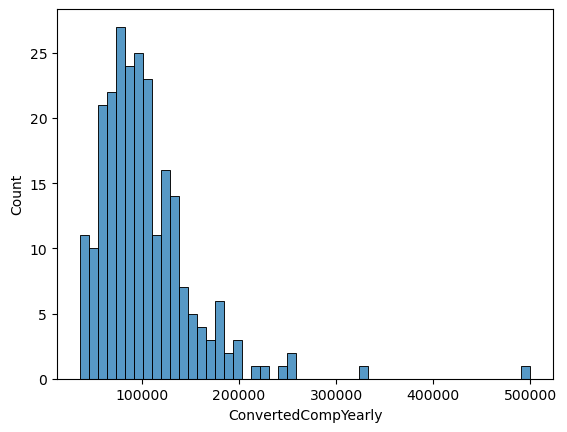

In [17]:
sns.histplot(us_clean.ConvertedCompYearly, bins= 50)

<Axes: >

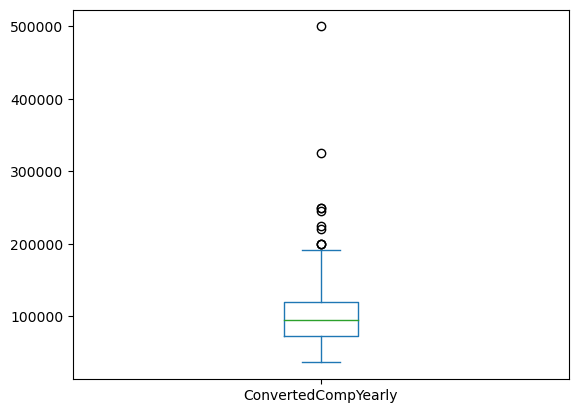

In [18]:
us_clean.ConvertedCompYearly.plot(kind= 'box')

In [19]:
us_clean.ConvertedCompYearly.skew()

2.9396980795170755

## Transformation & Trimming

Raw salary data in both groups showed high right skewness (6.45 and 2.93). To address this, we apply a natural log transformation using `np.log1p()`. Then, we will deal with outliers by applying pd.quantile() to remove extrem enteries. Our expectation is that both measuers will signfactly reduce skewness


In [20]:
de_clean['LogSalary'] = np.log1p(de_clean['ConvertedCompYearly'])
us_clean['LogSalary'] = np.log1p(us_clean['ConvertedCompYearly'])



/var/folders/tm/f180h_jd4k3678l687xfd8km0000gn/T/ipykernel_64092/2841278784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_clean['LogSalary'] = np.log1p(de_clean['ConvertedCompYearly'])
/var/folders/tm/f180h_jd4k3678l687xfd8km0000gn/T/ipykernel_64092/2841278784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_clean['LogSalary'] = np.log1p(us_clean['ConvertedCompYearly'])


<Axes: xlabel='LogSalary', ylabel='Count'>

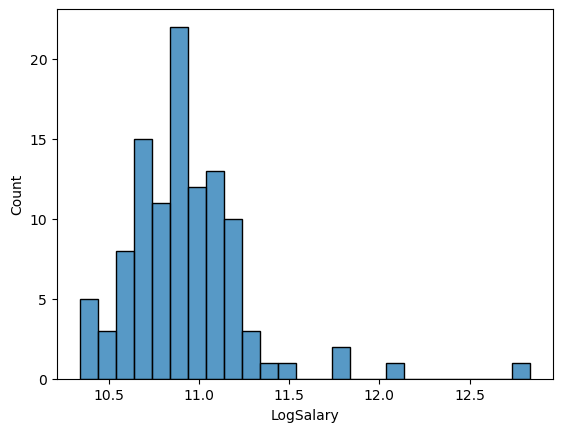

In [21]:
sns.histplot(de_clean.LogSalary, bins= 25)

<Axes: >

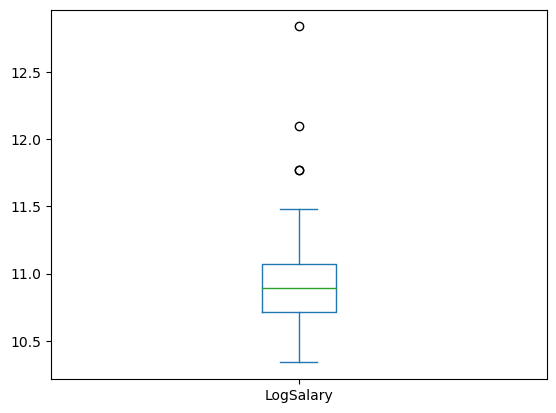

In [22]:
de_clean.LogSalary.plot(kind= 'box')

<Axes: xlabel='LogSalary', ylabel='Count'>

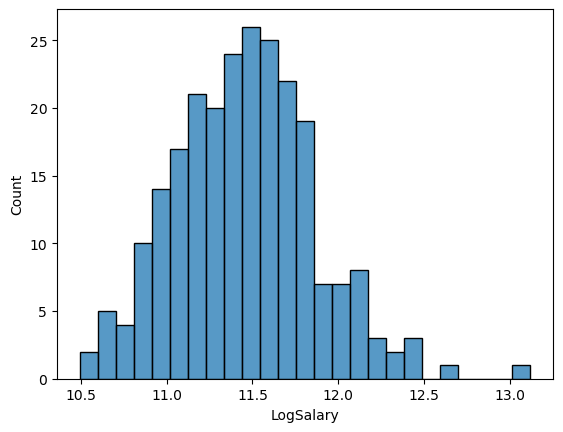

In [23]:
sns.histplot(us_clean.LogSalary, bins= 25)

<Axes: >

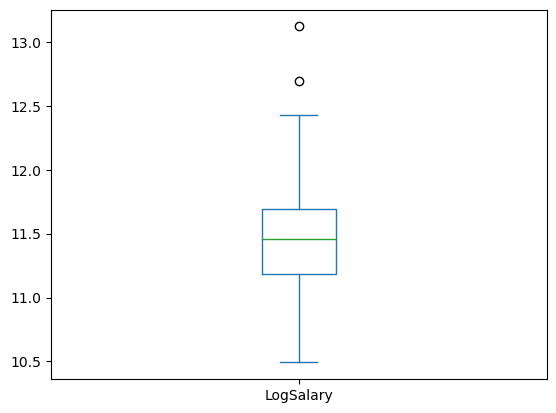

In [24]:
us_clean.LogSalary.plot(kind= 'box')

In [25]:
us_clean.LogSalary.skew()

0.3417234006565254

In [26]:
de_clean.LogSalary.skew()

2.0952890902664487

In [27]:
germany_98 = de_clean['LogSalary'].quantile(0.98)
de_clean_trimmed = de_clean[ de_clean['LogSalary'] < germany_98]

In [28]:
de_clean_trimmed.LogSalary.skew()


-0.017000280838482103

<Axes: xlabel='LogSalary', ylabel='Count'>

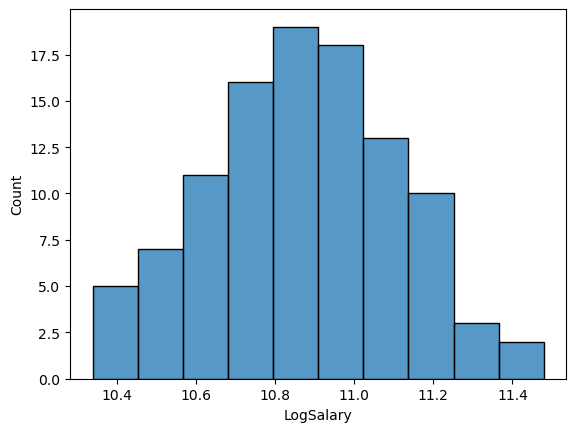

In [44]:
sns.histplot(de_clean_trimmed.LogSalary, bins= 10)

<Axes: >

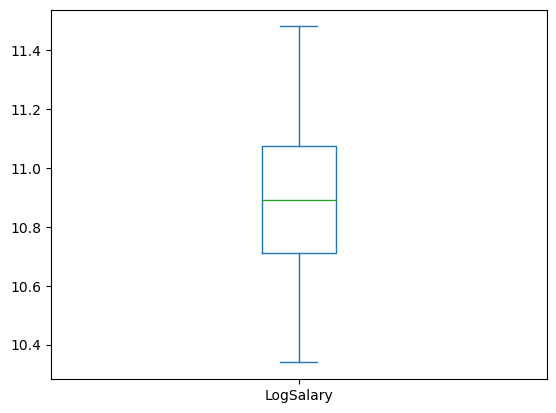

In [30]:
de_clean_trimmed.LogSalary.plot(kind= 'box')

In [31]:
us_99 = us_clean['LogSalary'].quantile(0.995)
us_clean_trimmed = us_clean[ us_clean['LogSalary'] < us_99]

In [32]:
us_clean_trimmed.LogSalary.skew()

0.03636784363494462

<Axes: xlabel='LogSalary', ylabel='Count'>

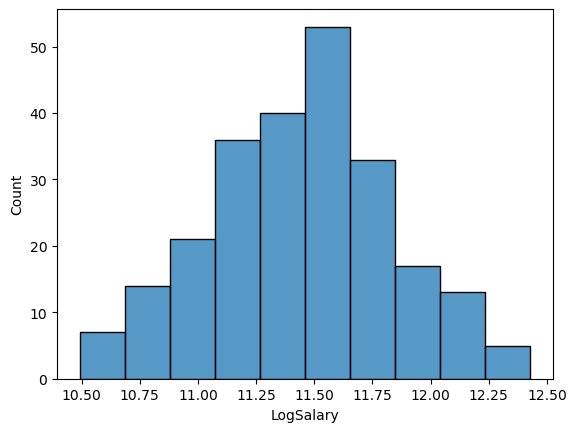

In [45]:
sns.histplot(us_clean_trimmed.LogSalary, bins= 10)

<Axes: >

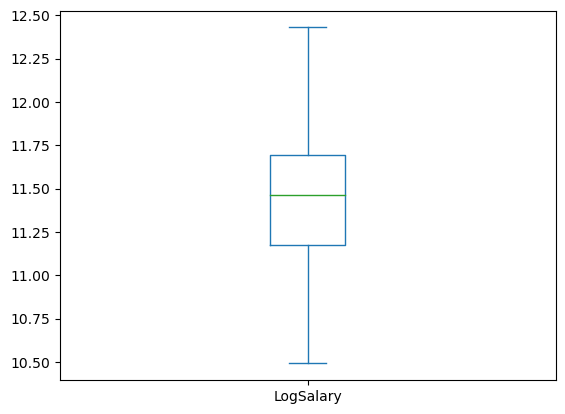

In [33]:
us_clean_trimmed.LogSalary.plot(kind= 'box')

## Hypothesis Testing

With our clean, transformed data, we formally test:
- **H₀:** US and German early-career developer salaries are equal (on average)
- **H₁:** There is a difference in average salaries

We use the Welch’s t-test, which is robust to unequal sample sizes and variances.


In [34]:
t_stat, p_val = ttest_ind(us_clean_trimmed.LogSalary, 
                          de_clean_trimmed.LogSalary, 
                          equal_var=False)

print(t_stat, p_val)

16.20288168803127 5.776035654572501e-43


## Calculating the Salary Gap

We compute the 95% confidence interval for the difference in log-mean salaries, then exponentiate to interpret the result as a percent difference in average salary between the US and Germany.


In [35]:
mean_de_log = de_clean_trimmed.LogSalary.mean()
mean_us_log = us_clean_trimmed.LogSalary.mean()

std_de_log = de_clean_trimmed.LogSalary.std(ddof=1)
std_us_log = us_clean_trimmed.LogSalary.std(ddof=1)

diff_m_log = mean_us_log - mean_de_log

print(mean_de_log,
      mean_us_log,
      std_de_log,
      std_us_log,
      diff_m_log)



10.881382600599588 11.442357236062094 0.24058000596683965 0.39175738292515533 0.5609746354625056


In [36]:
n1, n2 = len(de_clean_trimmed.LogSalary), len(us_clean_trimmed.LogSalary)

se1, se2 = std_de_log / np.sqrt(n1), std_us_log / np.sqrt(n2)

se_diff = np.sqrt(se1**2 + se2**2)

df = (se1**2 + se2**2)**2 / ((se1**4 / (n1-1)) + (se2**4 / (n2-1)))

t_crit = t.ppf(0.975, df )

moe = t_crit * se_diff

ci_lo = diff_m_log - moe 
ci_upp = diff_m_log + moe

print((ci_lo, ci_upp))



(0.4928449541783957, 0.6291043167466155)


In [37]:
print((np.expm1(ci_lo) * 100, np.expm1(ci_upp) * 100))


(63.696669686600835, 87.59295878424324)


## Regression Analysis

To see if the US–Germany gap remains after accounting for education and experience, we fit a regression model with:
- Outcome: Log salary
- Predictors: Country, education level, work experience

This lets us isolate the "country effect" net of these other important variables.


In [38]:
# Concatenate the cleaned dataframes
df_reg = pd.concat([de_clean_trimmed, us_clean_trimmed], axis=0)

# Fit the model (treat Country and EdLevel as categorical)
model = smf.ols('LogSalary ~ C(Country) + C(EdLevel) + WorkExp', data=df_reg).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              LogSalary   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     34.64
Date:                Sun, 06 Jul 2025   Prob (F-statistic):           1.16e-39
Time:                        20:09:39   Log-Likelihood:                -98.583
No. Observations:                 343   AIC:                             215.2
Df Residuals:                     334   BIC:                             249.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

## Regression Diagnostics

We check the normality of model residuals using a Q-Q plot. The residuals are nearly perfectly normal, confirming that our assumptions for inference are well satisfied.


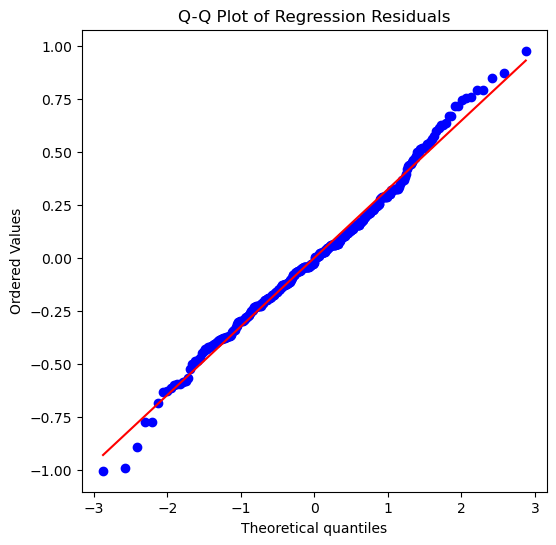

In [39]:
resd = model.resid
plt.figure(figsize=(6,6))
stats.probplot(resd, dist="norm", plot=plt)
plt.title("Q-Q Plot of Regression Residuals")
plt.show()

## Final Results and Interpretation

After rigorous data cleaning, outlier removal, and adjustment for education and work experience, our regression analysis shows:

- **Country effect (US vs. Germany):**
    - **t-statistic:** 13.108
    - **p-value:** p < 0.05
    - **Coefficient (log salary):** 0.5513
    - **Interpreted as percent difference:** US early-career developers earn about 73.5% more than their German counterparts (95% CI: 59.8% to 88.5%).

This effect is statistically significant after all adjustments. While a simple group comparison (t-test) also showed a large gap, the regression confirms that the difference persists even after accounting for differences in education and experience.

**Conclusion:**  
The salary gap between young developers in the US and Germany is large, robust, and statistically significant—even after controlling for key confounding factors.
